<a href="https://colab.research.google.com/github/suneetsawant/NewsMultilabel/blob/main/Qure_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3.0.0
!pip install -U -q PyDrive
!pip install httplib2==0.15.0
# 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
class Drive():   
  def __init__(self) :  
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    self.drive = GoogleDrive(gauth)


  def fileaction(self,files,op='up') : 
    file_list = self.drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for filename in files:
      flag = 0 

      for file1 in file_list:
        if (file1['title']) == filename :
            if (op == 'up'and flag==0) : 
                file1.Delete()
                self.upload(filename)
                flag = 1

            elif (op == 'down') : 
                self.download(filename,file1) 

      if(op=='up' and flag==0): 
            self.upload(filename)
            flag = 1

  def upload(self,filename) : 
      Uploadfile = self.drive.CreateFile({'title': filename})
      Uploadfile.SetContentFile(filename)
      Uploadfile.Upload()
      print("Saved '{}' to Drive".format(filename))

  def download(self,filename,file1): 
      downloaded = self.drive.CreateFile({'id':file1['id']})
      downloaded.GetContentFile(filename)
      print("Downloaded '{}' from Drive".format(filename))


In [2]:
import pandas as pd
import numpy as np 
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import TensorDataset,Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda
from transformers import AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,hamming_loss,roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='train.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

## Download Data

Download data **the_hindu_data.csv** from the google drive 



In [5]:
!gdown --id 1M0uWWKHjHFwEjrdYVDQSnYnWjuUdOyIe
# https://drive.google.com/file/d/1M0uWWKHjHFwEjrdYVDQSnYnWjuUdOyIe/view?usp=sharing
#https://drive.google.com/file/d/15alKiDAs2VRdlCVJKIwc4gSBedwbHdug/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1M0uWWKHjHFwEjrdYVDQSnYnWjuUdOyIe
To: /content/the_hindu_data.csv
363MB [00:02, 163MB/s]


## Data Analysis

In [6]:
df = pd.read_csv('the_hindu_data.csv')
df['section'].unique()


# df = df[:1000]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97305 entries, 0 to 97304
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      97305 non-null  object
 1   text     97305 non-null  object
 2   summary  97305 non-null  object
 3   title    97305 non-null  object
 4   tag      89431 non-null  object
 5   section  97305 non-null  object
dtypes: object(6)
memory usage: 4.5+ MB


In [7]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
replacement = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "tryin'":"trying",
}
class EnglishPreProcessor(object):
    def __init__(self,min_len = 2):
        self.min_len = min_len
        self.reset()

    def lower(self,sentence):
        '''
        '''
        return sentence.lower()

    def reset(self):
        '''
        '''
        self.stopwords = {}
        for line in stopwords.words('english'):
            word = line.strip(' ').strip('\n')
            self.stopwords[word] = 1


    def clean_length(self,sentence):
        '''
        :return:
        '''
        if len([x for x in sentence]) >= self.min_len:
            return sentence

    def replace(self,sentence):
        '''
        :return:
        '''
        # Replace words like gooood to good
        sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
        # Normalize common abbreviations
        words = sentence.split(' ')
        words = [replacement[word] if word in replacement else word for word in words]
        sentence_repl = " ".join(words)
        return sentence_repl

    def remove_website(self,sentence):
        '''
        '''
        sentence_repl = sentence.replace(r"http\S+", "")
        sentence_repl = sentence_repl.replace(r"https\S+", "")
        sentence_repl = sentence_repl.replace(r"http", "")
        sentence_repl = sentence_repl.replace(r"https", "")
        return sentence_repl

    def remove_name_tag(self,sentence):
        # Remove name tag
        sentence_repl = sentence.replace(r"@\S+", "")
        return sentence_repl

    def remove_time(self,sentence):
        '''
        '''
        # Remove time related text
        sentence_repl = sentence.replace(r'\w{3}[+-][0-9]{1,2}\:[0-9]{2}\b', "")  # e.g. UTC+09:00
        sentence_repl = sentence_repl.replace(r'\d{1,2}\:\d{2}\:\d{2}', "")  # e.g. 18:09:01
        sentence_repl = sentence_repl.replace(r'\d{1,2}\:\d{2}', "")  # e.g. 18:09
        # Remove date related text
        # e.g. 11/12/19, 11-1-19, 1.12.19, 11/12/2019
        sentence_repl = sentence_repl.replace(r'\d{1,2}(?:\/|\-|\.)\d{1,2}(?:\/|\-|\.)\d{2,4}', "")
        # e.g. 11 dec, 2019   11 dec 2019   dec 11, 2019
        sentence_repl = sentence_repl.replace(
            r"([\d]{1,2}\s(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)|(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s[\d]{1,2})(\s|\,|\,\s|\s\,)[\d]{2,4}",
            "")
        # e.g. 11 december, 2019   11 december 2019   december 11, 2019
        sentence_repl = sentence_repl.replace(
            r"[\d]{1,2}\s(january|february|march|april|may|june|july|august|september|october|november|december)(\s|\,|\,\s|\s\,)[\d]{2,4}",
            "")
        return sentence_repl

    def remove_breaks(self,sentence):
        # Remove line breaks
        sentence_repl = sentence.replace("\r", "")
        sentence_repl = sentence_repl.replace("\n", "")
        sentence_repl = re.sub(r"\\n\n", ".", sentence_repl)
        return sentence_repl

    def remove_ip(self,sentence):
        # Remove phone number and IP address
        sentence_repl = sentence.replace(r'\d{8,}', "")
        sentence_repl = sentence_repl.replace(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', "")
        return sentence_repl

    def adjust_common(self,sentence):
        # Adjust common abbreviation
        sentence_repl = sentence.replace(r" you re ", " you are ")
        sentence_repl = sentence_repl.replace(r" we re ", " we are ")
        sentence_repl = sentence_repl.replace(r" they re ", " they are ")
        sentence_repl = sentence_repl.replace(r"@", "at")
        return sentence_repl


    def remove_stopword(self,sentence):
        '''
        '''
        words = sentence.split()
        x = [word for word in words if word not in self.stopwords]
        return " ".join(x)

    def __call__(self, sentence):
        x = sentence
        x = self.lower(x)
        x = self.replace(x)
        x = self.remove_website(x)
        x = self.remove_name_tag(x)
        x = self.remove_time(x)
        x = self.remove_breaks(x)
        x = self.remove_ip(x)
        x = self.adjust_common(x)
        x = self.remove_stopword(x)
        return x
EnglishPreProcessor(5)('no above stop word required')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'stop word required'

### Word Count Distribution in Actual Text and Summary

Wholte Text word count: 75perc=300.0,max=11028,min=1
Summary word count: 75perc=79.0,max=462,min=1


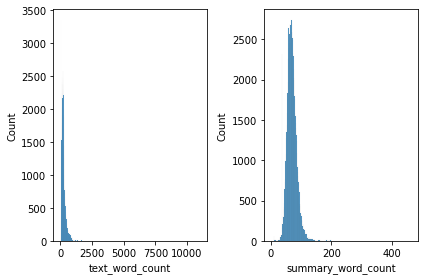

In [15]:
def word_count(sentence):
  return len(sentence.split(' '))

df['text'] = df['text'].apply(EnglishPreProcessor(5))
df['summary'] = df['summary'].apply(EnglishPreProcessor(5))

df['text_word_count'] = df['text'].apply(word_count) 
print('Wholte Text word count: 75perc={},max={},min={}'.format(df['text_word_count'].quantile(0.75),df['text_word_count'].max(),df['text_word_count'].min()))

df['summary_word_count'] = df['summary'].apply(word_count) 
print('Summary word count: 75perc={},max={},min={}'.format(df['summary_word_count'].quantile(0.75),df['summary_word_count'].max(),df['summary_word_count'].min()))

fig, ax = plt.subplots(1,2)
sns.histplot(df['text_word_count'], ax=ax[0])
sns.histplot(df['summary_word_count'], ax=ax[1])
fig.tight_layout()
fig.show()

### Split multiple labels into list of labels

For e.g  labels like 'Entertainment & Variety' are converted to lowercased and then split into ['Entertainment','Variety']


The delimiters for separation are '**,**', **'&',** '**and**' 

In [16]:
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def get_base_category(word):
   combination_map = {
       'agriculture':  ['agri','agri-business','agriculture'],
      'books' : ['anything but books','book','literary review'],
      'elections':['assembly elections','bihar assembly elections 2015','election','election data','lok sabha 2014',
                   'lok sabha election','kerala assembly elections 2016','puducherry assembly elections 2016','west bengal assembly elections 2016'
                   ],
      'economy' : ['economy watch','economy'],
      'delhi' : ['delhi 2020','delhi','new delhi',],
    'education' : ['education','education plus'],
    'motorsport':['motoring','motorsport'],
    'mumbai' : ['mumbai','mumbai local','bombay showcase'],
    'tamil nadu':['tamil nadu','tamil nadu 2016'],
    'tabloids':['a','q','know your english','nxg','rx'],
    'people': ['people','c.r.l. narasimhan','harsh mander','hasan suroor','makarand waingankar','sainath','sevanti ninan',
               'siddharth varadarajan','subramanian','suhasini haidar','ziya us salam','vijay nagaswami','bill kirkman',
               'chandrasekhar','j. murali','kalpana sharma','navtej sarna','nirmal shekar','yogacharini maitreyi'],
    'articles': ['articles','latest news','news','new articles',"today's paper",'impact journalism day 2017','india@70',
                 'sunday anchor','sunday magazine','the hindu @140'],
    'the cables':['the cables','the india cables'],
    'cricket':['champions trophy 2013','cricket'],
    'movies': ['cinema', 'movie'],
    'diet': ['nutrition','diet'],
    'karnataka':['karnataka','karnataka 2018'],
    'life':['life','lit for life'],
    'metro plus':['metro plus','metroplus']
   }

   for k,v in combination_map.items():
     if word in v:
       return k
   
   return word
def split_labels(labels):
  final_labels = []
  labels = re.split(r'[,]', labels)
  for label in labels :
     label = label.replace(' and ','&')
     temp = re.split(r'[;,&]', label)
     temp = [x.strip().lower() for x in temp if x != '']
     temp = [lemmatizer.lemmatize(x) for x in temp]
     temp = [get_base_category(x) for x in temp]
    #  temp = [x[:-1] if x.endswith('s') else x for x in temp ] 
     final_labels += temp
  return final_labels

split_labels('Entertainments & Variety')

# get_base_category('delhi')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['entertainment', 'variety']

### Create Mapping of labels 

In [17]:
class_labels = []
for labels in df['section'].unique():
   class_labels += split_labels(labels) 

class_labels = list(dict.fromkeys(class_labels))
label_map ={}
i = 0
for label in class_labels:
  label_map[label] = i
  i += 1
label_map = dict(sorted(label_map.items()))
print(label_map)

num_labels = len(label_map)
print(num_labels)
label_map['international']
inv_map = {v: k for k, v in label_map.items()}
print(inv_map)

{'agriculture': 80, 'andhra pradesh': 26, 'app exclusive': 142, 'archive': 132, 'art': 38, 'articles': 56, 'assam': 146, 'athletics': 86, 'author': 117, 'bengaluru': 58, 'bihar': 61, 'books': 3, 'brainteasers': 135, 'budget 2020': 118, 'business': 19, 'career': 79, 'cartoon': 10, 'chennai': 13, 'child': 70, 'city': 113, 'clarification': 94, 'coimbatore': 57, 'college': 75, 'column': 16, 'comment': 46, 'company': 106, 'correction': 93, 'craft': 125, 'cricket': 35, 'culture': 39, 'dance': 65, 'data': 18, 'datadelve': 127, 'delhi': 24, 'design': 115, 'diet': 133, 'down town': 136, 'east': 97, 'economy': 21, 'editorial': 9, 'education': 55, 'elections': 74, 'entertainment': 36, 'environment': 54, 'faith': 60, 'fashion': 126, 'fitness': 83, 'food': 51, 'football': 45, 'friday review': 124, 'gadget': 28, 'gallery': 129, 'garden': 108, 'green living': 116, 'health': 5, 'history': 53, 'hockey': 1, 'home': 107, 'home finance': 151, 'hyderabad': 29, 'in school': 145, 'in-depth': 68, 'industry': 

### Map the summary columns to get the one hot encoded output vectors

In [18]:
def get_output_list(labels,num_labels):
  output = [0]*num_labels
  for label in labels :
    output[label_map[label]] = 1
  return output

get_output_list(['cricket','science'],num_labels)
def get_output_label(label_str):
   label_list = split_labels(label_str)
   return get_output_list(label_list,num_labels) 

df['output_label'] = df['section'].apply(get_output_label) 


# df.head()

# get_output_label('International')
   

## Train- Test Split

In [ ]:

num_training_samples = len(df['summary'])#1000
train_data = df['summary'][:num_training_samples]
val_data = df['output_label'][:num_training_samples]

# train_data = new_df['comment_text'][:num_training_samples]
# val_data = new_df['list'][:num_training_samples]
train_text, val_text, train_labels, val_labels = train_test_split(train_data, val_data, 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                      )
# num_labels = 6
print(train_text.shape)
print(val_text.shape)
print(num_training_samples)
df.head()

In [20]:
# inv_map = {v: k for k, v in label_map.items()}

count_map = {}
for key in label_map.keys():
  count_map[key] = 0
for ele in df['output_label']:
  idx = np.where(np.array(ele)>0)[0] 
  for id in idx :
    count_map[inv_map[id]] += 1

keys = count_map.keys()
vals = count_map.values()

num_instances = 0
for k,v in count_map.items():
   if k=='international':
     print(k,v)
   num_instances += v
  
wts = {}
for k,v in count_map.items():
   if k=='international':
     print(k,v,num_instances)
   wts[k] = (num_instances-v)/v

wts_map = dict(sorted(wts.items()))
print(label_map)
print(wts_map)

wts_list = [1]*len(wts_map)
for k,v in wts_map.items():
  wts_list[label_map[k]] = v 

print(num_instances)
print(len(wts_list))
dff = pd.DataFrame.from_dict([count_map],orient='columns')
dff.head()


international 15852
international 15852 98322
{'agriculture': 80, 'andhra pradesh': 26, 'app exclusive': 142, 'archive': 132, 'art': 38, 'articles': 56, 'assam': 146, 'athletics': 86, 'author': 117, 'bengaluru': 58, 'bihar': 61, 'books': 3, 'brainteasers': 135, 'budget 2020': 118, 'business': 19, 'career': 79, 'cartoon': 10, 'chennai': 13, 'child': 70, 'city': 113, 'clarification': 94, 'coimbatore': 57, 'college': 75, 'column': 16, 'comment': 46, 'company': 106, 'correction': 93, 'craft': 125, 'cricket': 35, 'culture': 39, 'dance': 65, 'data': 18, 'datadelve': 127, 'delhi': 24, 'design': 115, 'diet': 133, 'down town': 136, 'east': 97, 'economy': 21, 'editorial': 9, 'education': 55, 'elections': 74, 'entertainment': 36, 'environment': 54, 'faith': 60, 'fashion': 126, 'fitness': 83, 'food': 51, 'football': 45, 'friday review': 124, 'gadget': 28, 'gallery': 129, 'garden': 108, 'green living': 116, 'health': 5, 'history': 53, 'hockey': 1, 'home': 107, 'home finance': 151, 'hyderabad': 29, 

,agriculture,andhra pradesh,app exclusive,archive,art,articles,assam,athletics,author,bengaluru,bihar,books,brainteasers,budget 2020,business,career,cartoon,chennai,child,city,clarification,coimbatore,college,column,comment,company,correction,craft,cricket,culture,dance,data,datadelve,delhi,design,diet,down town,east,economy,editorial,...,sci-tech,science,section,short,signpost,sikkim,society,south,south asia,special,sport,state,style,tabloids,tale,tamil nadu,technology,telangana,television,tennis,terrorism,the cables,theatre,thiruvananthapuram,thread,timeline,tiruchirapalli,travel,variety,video,view,vijayawada,visakhapatnam,web exclusives,west,women in action,world,world cup,young world,youth
0,139,3803,2,131,441,1496,12,44,72,742,91,134,31,132,763,129,38,843,185,4,51,467,134,415,1991,441,51,69,728,446,129,85,12,1732,37,26,3,10,1511,1468,...,138,499,1,1,7,1,545,11,1310,59,105,206,38,105,1,3127,592,925,25,137,1,142,124,305,6,6,332,262,29,51,12,771,737,6,10,25,2630,44,77,4


## Data Loader


In [21]:
# Sections of config
max_seq_len = 80
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [22]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [23]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist(),dtype=torch.float)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist(),dtype=torch.float)

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 256

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = AutoModel.from_pretrained('bert-base-uncased')
        for param in self.l1.parameters():
            param.requires_grad = False
        self.dropout = torch.nn.Dropout(0.3)
        self.l5 = torch.nn.Linear(768,num_labels)
    
    def forward(self, ids, mask):
        _, output_1= self.l1(ids, attention_mask = mask)
        output_2 = self.dropout(output_1) 
        out = self.l5(output_2)
        return out

model = BERTClass()
model.to(device)

In [27]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [28]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(wts_list).to(device))(outputs, targets)

In [31]:
# function to train the model
def train():
    model.train()
    total_loss,total_roc = 0,0
    total_preds=[]
    for step,batch in enumerate(train_dataloader):
      if step % 50 == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
          print('roc',roc)
      batch = [r.to(device) for r in batch]
      sent_id, mask, labels = batch

      model.zero_grad()        
      preds = model(sent_id, mask)
      loss = loss_fn(preds, labels)
      total_loss = total_loss + loss.item()
      loss.backward()
      optimizer.step()
      labels = labels.detach().cpu().numpy()
      preds = preds.sigmoid().detach().cpu().numpy()

      try:
        roc= roc_auc_score(labels,preds,average='micro')
      except:
        roc = 0
      total_roc+= roc

    avg_loss = total_loss / len(train_dataloader)
    avg_roc = total_roc / len(train_dataloader)
  
    return avg_loss,avg_roc

In [32]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")
    model.eval()
    total_loss,total_roc = 0, 0 
    total_preds = []

    for step,batch in enumerate(val_dataloader):

        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
            print('roc',roc)
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
          
          preds = model(sent_id, mask)
          loss = loss_fn(preds,labels)
          total_loss = total_loss + loss.item()
          preds = preds.sigmoid().data.cpu().numpy()
          labels = labels.detach().cpu().numpy()
          # roc_curve(labels,preds)
          try:
            roc= roc_auc_score(labels,preds,average='micro')
          except:
            print('Exception')
            roc = 0
          total_roc += roc
    avg_loss = total_loss / len(val_dataloader) 
    avg_roc  = total_roc/len(val_dataloader) 

    return avg_loss, avg_roc


def roc_curve(label,preds):

    print(label.shape)
    for i in range(label.shape[1]):
      fpr, tpr, thresholds = metrics.roc_curve(label[:,i], preds[:,i])
      plt.subplots(figsize=(10, 6))
      plt.plot(fpr, tpr, 'o-', label="ROC curve")
      plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
      for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
          plt.annotate(np.round(txt,2), (x, y-0.04))
      rnd_idx = 27
      plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
                  xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
                  arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
      plt.legend(loc="upper left")
      plt.xlabel("FPR")
      plt.ylabel("TPR")
      plt.show()
      print(thresholds)



In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
epochs = 100
#for each epoch 
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss,train_roc = train()
    val_loss,val_roc = evaluate()
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
        Drive().fileaction(['saved_weights.pt'],'up')
    
    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    
    logging.info(f' Epoch {epoch} / {epochs}')
    logging.info(f'Training Loss: {train_loss:.3f}, Auc-roc:{train_roc}')
    logging.info(f'Validation Loss: {val_loss:.3f}, Auc-roc:{val_roc}')
    print(f'Training Loss: {train_loss:.3f}, Auc-roc:{train_roc}')
    print(f'Validation Loss: {val_loss:.3f},Auc-roc:{val_roc}',)
    Drive().fileaction(['train.log'],'up')


 Epoch 1 / 100
  Batch    50  of    305.
roc 0.676033808990355
  Batch   100  of    305.
roc 0.7173636345522874
  Batch   150  of    305.
roc 0.7488059341667057
  Batch   200  of    305.
roc 0.7747608236315452
  Batch   250  of    305.
roc 0.7920414501468078


In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# evaluate()

<All keys matched successfully>

In [ ]:
from google.colab import files
files.download(path)

In [ ]:
!du -sh saved_weights.pt

In [ ]:
# !pip install httplib2==0.15.0
Drive().fileaction(['saved_weights.pt'],'up')

In [ ]:
## Inference 

test_sentence = "Virat kohli is great cricketer."
tokenized_text = tokenizer.tokenize(test_sentence) 
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
tokens = tokenizer.encode_plus(test_sentence)
train_seq = torch.tensor(tokens_train['input_ids']).to(device)
train_mask = torch.tensor(tokens_train['attention_mask']).to(device)

model.eval()
model(train_seq,train_mask)